In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio

# traindata loader

In [ ]:
from pathlib import Path
import rasterio
import os
import numpy as np

import torch
import torch.autograd as autograd
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader


class DEM_Data(Dataset):

    def __init__(self, tif_dir, augment=True, cuda=False):
        files = os.listdir(tif_dir)
        self.paths = [(tif_dir / i) for i in files if i.endswith(".tif")]
        self.total_files = len(self.paths)
        self.cuda = cuda
        self.data = []
        self.faulty_files = 0

        for index, file_path in enumerate(self.paths):
          if index % 100 == 0:
            print(f"{index}/{len(self.paths)}")
          with rasterio.open(file_path) as handle:
            augmentations = []

            if handle.shape != (500,500):
              faulty_files += 1
              print(f"wrong shape {faulty_files}")
              continue
            dem_array = handle.read(1)[0:495,0:495]
            dem_array = dem_array[np.newaxis, ...]
            augmentations.append(dem_array)

            if augment:
              augmentations.append(np.rot90(dem_array, 1,(1,2)))
              augmentations.append(np.rot90(dem_array, 2,(1,2)))
              augmentations.append(np.rot90(dem_array, 3,(1,2)))
              augmentations.append(np.flip(dem_array,1))
              augmentations.append(np.flip(dem_array,2))

            for i in augmentations:
              self.data.append(i)



    def __getitem__(self, idx):
      if self.cuda:
        return torch.cuda.FloatTensor(self.data[idx].copy())
      else:
          return torch.FloatTensor(self.data[idx].copy())

        

    

    def __len__(self):
        return len(self.data)


class DataLD(object):
    def __init__(self, tif_dir, augment=False, cuda=False):
        self.dataset = DEM_Data(tif_dir, augment, cuda)

    def get_loader(self, shuf=True, batch_size=1):
        data_loader = DataLoader(dataset=self.dataset,
                                 batch_size=batch_size,
                                 shuffle=shuf
                                 )
        return data_loader


# model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvAE(nn.Module):

    def __init__(self):
        super(ConvAE, self).__init__()

        # shape (1001, 1251, 1)
        self.conv1 = nn.Conv2d(1, 24, 4, padding = 1)
        self.conv2 = nn.Conv2d(24, 16, 4,padding = 1)
        self.conv3 = nn.Conv2d(16, 4, 4, padding= 1)

        self.pool = nn.MaxPool2d(2,2)

        self.t_conv1= nn.ConvTranspose2d(4, 16, 2, stride=2, output_padding=1)
        self.t_conv2= nn.ConvTranspose2d(16, 24, 2, stride=2, output_padding =1)
        self.t_conv3= nn.ConvTranspose2d(24, 1, 2, stride=2, output_padding =1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)


        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        # linear output layer for reconstruction
        x = self.t_conv3(x)

        return x


# Fixing

In [ ]:

tif_dir = Path("/content/drive/MyDrive/data/train/")
test_data = DataLD(tif_dir, True)
data_loader = test_data.get_loader(batch_size= 30)
batch_losses = []
for i in data_loader:
  print(i.shape)
  break



KeyboardInterrupt: ignored

# Training 

In [ ]:
def train_epoch(model, data, loss_function, optimizer, batch_size):
  
  batch_losses = []
  model.cuda()
  model.batch_size = batch_size

  for index, batch in enumerate(data):
      optimizer.zero_grad()
      output = model(batch)

      #print(f"output:{output.shape} input:{batch.shape}")

      loss = loss_function(output, batch)

      batch_losses.append(loss.item())

      loss.backward()
    
      optimizer.step()
      #print(f"batch: {index}/{len(data)} - loss: {loss.item()}")
  return mean(batch_losses)


In [ ]:
def test(model, data, loss_function ,batch_size=1):
  with torch.no_grad():
    model.batch_size = batch_size
    conc_out = []
    conc_batch = []
    for index, batch in enumerate(data):
      
      output = model(batch)
      conc_out.append(output.cpu())
      conc_batch.append(batch.cpu())
    conc_out = torch.cat(conc_out)
    conc_batch = torch.cat(conc_batch)
    val_loss  = loss_function(conc_out, conc_batch)
    print(val_loss.item())

  return val_loss.data




In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def train(model, train, dev, loss_function, optimizer, epochs, batch_size, writer=None):
  loss_history = []
  for i in range(epochs):
    print(f"epoch:{i}")
    epoch_loss = train_epoch(model,train,loss_function, optimizer, batch_size)
    test_loss = test(model, dev, loss_function)
    loss_history.append((epoch_loss,test_loss))
    print(f"train loss: {epoch_loss}, test loss: {test_loss}")
    plt.plot(loss_history)
    plt.show()
  

In [ ]:
tif_dir = Path("/content/drive/MyDrive/data/")
train_data = DataLD(tif_dir / "train",True, True)
train_loader = train_data.get_loader(batch_size = 20)

dev_data = DataLD(tif_dir / "dev",False, True)
dev_loader = dev_data.get_loader(batch_size = 1)

0/2240


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


100/2240
200/2240
300/2240
400/2240
500/2240
600/2240
700/2240
800/2240
900/2240
1000/2240
1100/2240
1200/2240
1300/2240
1400/2240
1500/2240


Selected device: cuda
epoch:0
821606.8125
train loss: 11054522.371210007, test loss: 821606.8125


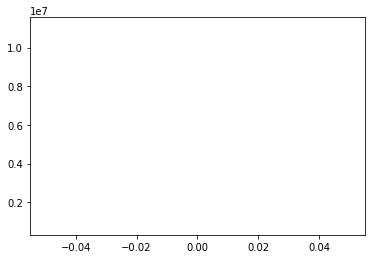

epoch:1
818805.9375
train loss: 701139.3922293527, test loss: 818805.9375


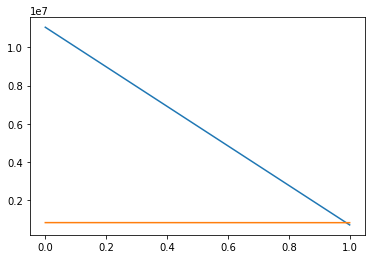

epoch:2
816201.4375
train loss: 698757.8029901413, test loss: 816201.4375


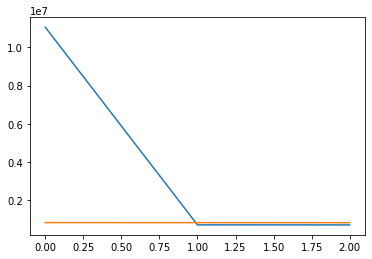

epoch:3
818753.0625
train loss: 697942.5186941965, test loss: 818753.0625


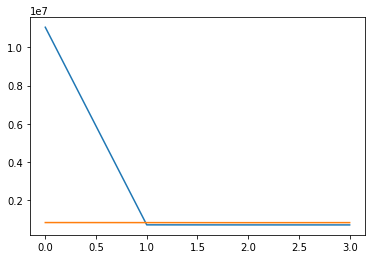

epoch:4
810931.875
train loss: 696419.8776274181, test loss: 810931.875


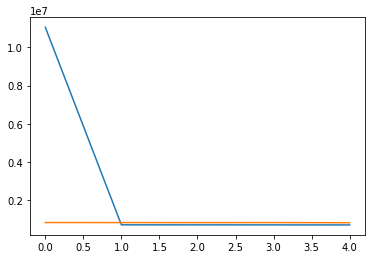

epoch:5


In [ ]:
from statistics import mean


model = ConvAE()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
model.to(device)



loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
train(model, train_loader, dev_loader, loss_function, optimizer, 40, 10)

# Testing

In [ ]:
os.getcwd()

'/content'